# Кластеризация. Домашка

## Совсем простая рекомендательная система

На основе оценок аниме, которые ставят пользователи систем типа [MAL](https://myanimelist.net/), можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)
- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную



In [2]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [3]:
anime = pd.read_csv('data/anime/anime.csv', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
ratings = pd.read_csv('data/anime/rating.csv')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

Во первых, в датасете есть много -1. Оценки -1 и 0 на MAL нет. 

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут. 

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее. 

### 1. Избавьтесь от -1

In [6]:
import pandas as pd

ratings = pd.read_csv('data/anime/rating.csv')

ratings_cleaned = ratings[ratings['rating'] != -1]

print(ratings_cleaned.shape)
ratings_cleaned.head()


(6337241, 3)


,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


## Критерий Шавене (Chauvenet)

[Теория](https://www.youtube.com/watch?v=Fy9pHH3ykPE&list=PLLyuiBK_HOLPfRVN6r9305FKXq1ravbbX)

$$ \operatorname{erfc}(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

`erfc` — это дополнительная функция ошибок Гаусса. [wiki](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA)

$$\operatorname{erfc}\,x = 1-\operatorname{erf}\,x = \frac{2}{\sqrt{\pi}} \int\limits_x^{\infty} e^{-t^2}\,\mathrm dt$$

$$\operatorname{erf}\,x = \frac{2}{\sqrt{\pi}}\int\limits_0^x e^{-t^2}\,\mathrm dt$$

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn. 

In [7]:
import numpy as np
from scipy.special import erfc
import pandas as pd

anime = pd.read_csv('data/anime/anime.csv', index_col='anime_id')
ratings = pd.read_csv('data/anime/rating.csv')

def chauvenet(array):
    mean = np.mean(array)
    std_dev = np.std(array)
    Z = np.abs(array - mean) / std_dev
    P = erfc(Z / np.sqrt(2))
    threshold = 1.0 / (2 * len(array))
    return P >= threshold

mask = chauvenet(anime['rating'])

anime_without_outliers = anime[mask]

print("Исходное число записей:", len(anime))
print("Число записей без выбросов:", len(anime_without_outliers))


Исходное число записей: 12294
Число записей без выбросов: 12060


Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [8]:
count_reviews = ratings_cleaned.groupby('user_id')['anime_id'].count()
count_reviews = count_reviews.to_frame(name='count_reviews')
print(count_reviews.head())


         count_reviews
user_id               
1                    4
2                    1
3                   92
5                  459
7                  343


### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в 1 теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [9]:
mask = chauvenet(count_reviews['count_reviews'].values)
outlier_users = count_reviews[~mask]
print(outlier_users)


         count_reviews
user_id               
226                742
446                743
478                863
958                783
1145               904
...                ...
70953              830
71792             1014
73135              986
73234              812
73378              723

[550 rows x 1 columns]


### 5. Ответьте на вопросы

#### Кого критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Нужна ли им вообще рекомендательная система?


**Ответы:**

**Ответ на 1 вопрос:** Критерий посчитал выбросами пользователей, которые посмотрели значительно больше аниме, чем средний пользователь в выборке.

**Ответ на 2 вопрос:** Критерий выявляет аномальные значения, сравнивая их с нормальным распределением данных. Пользователи с числом просмотренных аниме, значительно превышающим среднее (по сравнению со стандартным отклонением), имеют очень низкую вероятность быть частью нормального распределения, и поэтому они классифицируются как выбросы.

**Ответ на 3 вопрос:** Этим пользователям, скорее всего, рекомендательная система не нужна. Они посмотрели настолько много аниме, что либо уже знают свои предпочтения, либо имеют доступ к широкому спектру данных, что делает рекомендации для них менее полезными.

In [10]:
bad_user_threshold = outlier_users['count_reviews'].min()
print("Порог bad_user_threshold:", bad_user_threshold)
filtered_users = count_reviews[count_reviews['count_reviews'] < bad_user_threshold]
print("Количество пользователей после фильтрации:", len(filtered_users))


Порог bad_user_threshold: 701
Количество пользователей после фильтрации: 69050


Если все было правильно `bad_user_threshold` больше 500. 

Нужно выбросить всех людей у которых число просмотренных аниме больше или равно `bad_user_threshold`.

### 6. Переименнуйте столбец из таблицы `count_reviews` в `count_reviews` (он там единственный). Соедините `count_reviews` и `ratings` по столбцу `user_id`. И оставьте в `ratings` только тех кто посмотрел меньше `bad_user_threshold`  

In [11]:
count_reviews.rename(columns={'count_reviews': 'count_reviews'}, inplace=True)
ratings = ratings_cleaned.merge(count_reviews, on='user_id')
ratings = ratings[ratings['count_reviews'] < bad_user_threshold]
print("Число записей в ratings после фильтрации:", len(ratings))
ratings.head()


Число записей в ratings после фильтрации: 5804470


,user_id,anime_id,rating,count_reviews
0,1,8074,10,4
1,1,11617,10,4
2,1,11757,10,4
3,1,15451,10,4
4,2,11771,10,1


Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [12]:
ratings = ratings_cleaned.merge(count_reviews, on='user_id', how='inner')
median_reviews = ratings['count_reviews'].median()
print(f" Медианное количество просмотров: {median_reviews}")

ratings = ratings[ratings['count_reviews'] >= median_reviews]
print("Число записей в ratings после удаления пользователей с низкой активностью:", len(ratings))
ratings


 Медианное количество просмотров: 200.0
Число записей в ratings после удаления пользователей с низкой активностью: 3179775


,user_id,anime_id,rating,count_reviews
97,5,6,8,459
98,5,15,6,459
99,5,17,6,459
100,5,18,6,459
101,5,20,6,459
...,...,...,...,...
6336853,73507,8231,5,259
6336854,73507,8348,5,259
6336855,73507,8440,7,259
6336856,73507,8769,8,259


In [13]:
ratings = ratings.drop(columns=['count_reviews'])

ratings


,user_id,anime_id,rating
97,5,6,8
98,5,15,6
99,5,17,6
100,5,18,6
101,5,20,6
...,...,...,...
6336853,73507,8231,5
6336854,73507,8348,5
6336855,73507,8440,7
6336856,73507,8769,8


Теперь рассмотрим таблицу `anime`. 


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [14]:
import pandas as pd
from scipy.special import erfc

anime_file_path = 'data/anime/anime.csv'
anime = pd.read_csv(anime_file_path, index_col='anime_id')
anime.dropna(inplace=True)
print(f"Размер таблицы anime: {anime.shape}")
print(anime.head())

def chauvenet(array):
    mean = np.mean(array)  
    std_dev = np.std(array)  
    n = len(array)  
    threshold = 1. / (2 * n)  
    deviation = np.abs(array - mean) / std_dev
    mask = erfc(deviation / np.sqrt(2)) < threshold
    return mask

mask_rating = chauvenet(anime['rating'].values)
mask_members = chauvenet(anime['members'].values)
mask_combined = mask_rating & mask_members
outlier_anime = anime[~mask_combined]
anime_cleaned = anime[mask_combined]

print(f"Число аниме до удаления выбросов: {len(anime)}")
print(f"Число выбросов: {len(outlier_anime)}")
print(f"Число аниме после удаления выбросов: {len(anime_cleaned)}")

print("Пример выбросов:")
print(outlier_anime.head())

print("Очищенная таблица:")
print(anime_cleaned.head())


Размер таблицы anime: (12017, 6)
                                      name  \
anime_id                                     
32281                       Kimi no Na wa.   
5114      Fullmetal Alchemist: Brotherhood   
28977                             Gintama°   
9253                           Steins;Gate   
9969                         Gintama&#039;   

                                                      genre   type episodes  \
anime_id                                                                      
32281                  Drama, Romance, School, Supernatural  Movie        1   
5114      Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64   
28977     Action, Comedy, Historical, Parody, Samurai, S...     TV       51   
9253                                       Sci-Fi, Thriller     TV       24   
9969      Action, Comedy, Historical, Parody, Samurai, S...     TV       51   

          rating  members  
anime_id                   
32281       9.37   200630  
5114  

### 9. Ответье на вопросы

#### Что критерий посчитал выбросом? 

#### Почему критерий посчитал их выбросом? 

#### Можем ли мы как то использовать эти аниме в нашей рекомендательное системе? 

**Ответы:**

**Ответ на 1 вопрос:** Критерий Шовене посчитал выбросами аниме, у которых значения столбцов rating (средний рейтинг) и members (число участников группы) значительно отклоняются от среднего значения по всему датасету. Это могут быть как очень высокие, так и очень низкие значения, которые редко встречаются.

**Ответ на 2 вопрос:** Эти аниме имеют значения, которые сильно отличаются от большинства других аниме.

**Ответ на 3 вопрос:** Да
Популярные аниме (с высокими members) обычно хорошо подходят для рекомендаций новичкам, так как они привлекают внимание большого числа пользователей.
Непопулярные или низкорейтинговые аниме могут быть полезны для нишевых рекомендаций или специфических запросов пользователей с необычными вкусами.

## Кластеризация по жанрам

Данные о жанре хранятся как строка, разделенная запятой `,` . Но нам нужны сами жанры. Придется поколдовать и разделить эту строку на элементы. 

In [15]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. В конфе происходит flatten - уплощение списка скписков в один список.
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [16]:
# создаем функцию, которая просто разбивает строку по символу ", " на подстроки
def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Sci-Fi, Thriller' 'Comedy, Drama, School, Shounen, Sports'
 'Action, Adventure, Shounen, Super Power'
 'Drama, Military, Sci-Fi, Space'
 'Drama, Fantasy, Romance, Slice of Life, Supernatural'
 'Drama, School, Shounen'
 'Action, Drama, Mecha, Military, Sci-Fi, Super Power']
len= 3229

Genres=['Super Power', 'Supernatural', 'Yuri', 'Yaoi', 'Kids', 'Hentai', 'Ecchi', 'Romance', 'Shoujo', 'Martial Arts', 'Vampire', 'Music', 'Psychological', 'Thriller', 'Sci-Fi', 'Demons', 'Cars', 'Shounen Ai', 'Horror', 'Adventure', 'Harem', 'Police', 'Sports', 'Dementia', 'Military', 'Shounen', 'Mecha', 'Space', 'Shoujo Ai', 'Josei', 'Magic', 'Mystery', 'Comedy', 'School', 'Slice of Life', 'Seinen', 'Samurai', 'Fantasy', 'Action', 'Drama', 'Historical', 'Parody', 'Game']
len=43


### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [17]:
import pandas as pd
import numpy as np

anime_file_path = 'data/anime/anime.csv'
ratings_file_path = 'data/anime/rating.csv'

anime = pd.read_csv(anime_file_path, index_col='anime_id')
ratings = pd.read_csv(ratings_file_path)

anime.dropna(inplace=True)

print(f"Размер таблицы anime: {anime.shape}")
print(anime.head())
print(f"Размер таблицы ratings: {ratings.shape}")
print(ratings.head())

genres_split = anime['genre'].str.split(', ')

genres_encoded = genres_split.explode().reset_index()
genres_encoded = pd.get_dummies(genres_encoded, columns=['genre']).groupby('anime_id').sum()

genres_encoded.columns = [col.split('_')[-1] for col in genres_encoded.columns]  # Убираем 'genre_' из названий
genres_encoded.index = anime.index

print(f"Размер таблицы жанров: {genres_encoded.shape}")
print(genres_encoded.head())

ratings_with_genres = ratings.merge(genres_encoded, left_on='anime_id', right_index=True)
for genre in genres_encoded.columns:
    ratings_with_genres[genre] = ratings_with_genres['rating'] * ratings_with_genres[genre]
user_genre_ratings = ratings_with_genres.groupby('user_id')[genres_encoded.columns].mean()

print(f"Размер таблицы пользователь-жанр: {user_genre_ratings.shape}")
print(user_genre_ratings.head())

print("Пример таблицы жанров (genres_encoded):")
print(genres_encoded.head())

print("Пример таблицы пользователь-жанр (user_genre_ratings):")
print(user_genre_ratings.head())


Размер таблицы anime: (12017, 6)
                                      name  \
anime_id                                     
32281                       Kimi no Na wa.   
5114      Fullmetal Alchemist: Brotherhood   
28977                             Gintama°   
9253                           Steins;Gate   
9969                         Gintama&#039;   

                                                      genre   type episodes  \
anime_id                                                                      
32281                  Drama, Romance, School, Supernatural  Movie        1   
5114      Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64   
28977     Action, Comedy, Historical, Parody, Samurai, S...     TV       51   
9253                                       Sci-Fi, Thriller     TV       24   
9969      Action, Comedy, Historical, Parody, Samurai, S...     TV       51   

          rating  members  
anime_id                   
32281       9.37   200630  
5114  

Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [18]:
df = ratings.merge(genres_encoded, left_on='anime_id', right_index=True)
print(f"Размер соединённой таблицы: {df.shape}")
df

Размер соединённой таблицы: (7813611, 46)


,user_id,anime_id,rating,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,20,-1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,24,-1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,79,-1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,226,-1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,241,-1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813732,73515,16512,7,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7813733,73515,17187,9,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7813734,73515,22145,10,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
7813735,73516,790,9,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


С такой таблицей `(N*M) * G` вы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [19]:
df_with_nan = df.copy()
genre_columns = genres_encoded.columns
df_with_nan[genre_columns] = df_with_nan[genre_columns].replace(0, np.nan)

user_genre_mean = df_with_nan.groupby('user_id')[genre_columns].mean()

user_genre_mean = user_genre_mean.fillna(-1)

print(f"Размер таблицы с средними оценками по жанрам для каждого пользователя: {user_genre_mean.shape}")
print(user_genre_mean.head())

Размер таблицы с средними оценками по жанрам для каждого пользователя: (73515, 43)
         Action  Adventure  Cars  Comedy  Dementia  Demons  Drama  Ecchi  \
user_id                                                                    
1           1.0        1.0  -1.0     1.0       1.0     1.0    1.0    1.0   
2           1.0        1.0  -1.0     1.0      -1.0    -1.0    1.0   -1.0   
3           1.0        1.0   1.0     1.0      -1.0     1.0    1.0    1.0   
4           1.0        1.0  -1.0     1.0      -1.0     1.0    1.0    1.0   
5           1.0        1.0   1.0     1.0       1.0     1.0    1.0    1.0   

         Fantasy  Game  ...  Shounen Ai  Slice of Life  Space  Sports  \
user_id                 ...                                             
1            1.0   1.0  ...         1.0            1.0    1.0     1.0   
2            1.0  -1.0  ...        -1.0            1.0   -1.0     1.0   
3            1.0  -1.0  ...         1.0            1.0    1.0     1.0   
4            1.0  -

Так как некоторые пользователи не смотрели ничего из некоторых жанров, в данных осталось много `np.NaN`
### 13. Заполните все NaN на -1

**Hint** [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [20]:
user_genre_mean = user_genre_mean.fillna(-1)

print(user_genre_mean.head())

         Action  Adventure  Cars  Comedy  Dementia  Demons  Drama  Ecchi  \
user_id                                                                    
1           1.0        1.0  -1.0     1.0       1.0     1.0    1.0    1.0   
2           1.0        1.0  -1.0     1.0      -1.0    -1.0    1.0   -1.0   
3           1.0        1.0   1.0     1.0      -1.0     1.0    1.0    1.0   
4           1.0        1.0  -1.0     1.0      -1.0     1.0    1.0    1.0   
5           1.0        1.0   1.0     1.0       1.0     1.0    1.0    1.0   

         Fantasy  Game  ...  Shounen Ai  Slice of Life  Space  Sports  \
user_id                 ...                                             
1            1.0   1.0  ...         1.0            1.0    1.0     1.0   
2            1.0  -1.0  ...        -1.0            1.0   -1.0     1.0   
3            1.0  -1.0  ...         1.0            1.0    1.0     1.0   
4            1.0  -1.0  ...        -1.0            1.0    1.0     1.0   
5            1.0   1.0  ...  

Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(user_genre_mean)

scaled_df = pd.DataFrame(scaled_data, columns=user_genre_mean.columns, index=user_genre_mean.index)

print(scaled_df.head())


         Action  Adventure  Cars  Comedy  Dementia  Demons  Drama  Ecchi  \
user_id                                                                    
1           1.0        1.0   0.0     1.0       1.0     1.0    1.0    1.0   
2           1.0        1.0   0.0     1.0       0.0     0.0    1.0    0.0   
3           1.0        1.0   1.0     1.0       0.0     1.0    1.0    1.0   
4           1.0        1.0   0.0     1.0       0.0     1.0    1.0    1.0   
5           1.0        1.0   1.0     1.0       1.0     1.0    1.0    1.0   

         Fantasy  Game  ...  Shounen Ai  Slice of Life  Space  Sports  \
user_id                 ...                                             
1            1.0   1.0  ...         1.0            1.0    1.0     1.0   
2            1.0   0.0  ...         0.0            1.0    0.0     1.0   
3            1.0   0.0  ...         1.0            1.0    1.0     1.0   
4            1.0   0.0  ...         0.0            1.0    1.0     1.0   
5            1.0   1.0  ...  

### 15.Натренируйте kMeans с 10 кластерами на полученных данных

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(scaled_df)
labels = kmeans.labels_
scaled_df['cluster'] = labels
print(scaled_df.head())


         Action  Adventure  Cars  Comedy  Dementia  Demons  Drama  Ecchi  \
user_id                                                                    
1           1.0        1.0   0.0     1.0       1.0     1.0    1.0    1.0   
2           1.0        1.0   0.0     1.0       0.0     0.0    1.0    0.0   
3           1.0        1.0   1.0     1.0       0.0     1.0    1.0    1.0   
4           1.0        1.0   0.0     1.0       0.0     1.0    1.0    1.0   
5           1.0        1.0   1.0     1.0       1.0     1.0    1.0    1.0   

         Fantasy  Game  ...  Slice of Life  Space  Sports  Super Power  \
user_id                 ...                                              
1            1.0   1.0  ...            1.0    1.0     1.0          1.0   
2            1.0   0.0  ...            1.0    0.0     1.0          0.0   
3            1.0   0.0  ...            1.0    1.0     1.0          1.0   
4            1.0   0.0  ...            1.0    1.0     1.0          1.0   
5            1.0   1.0 

### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

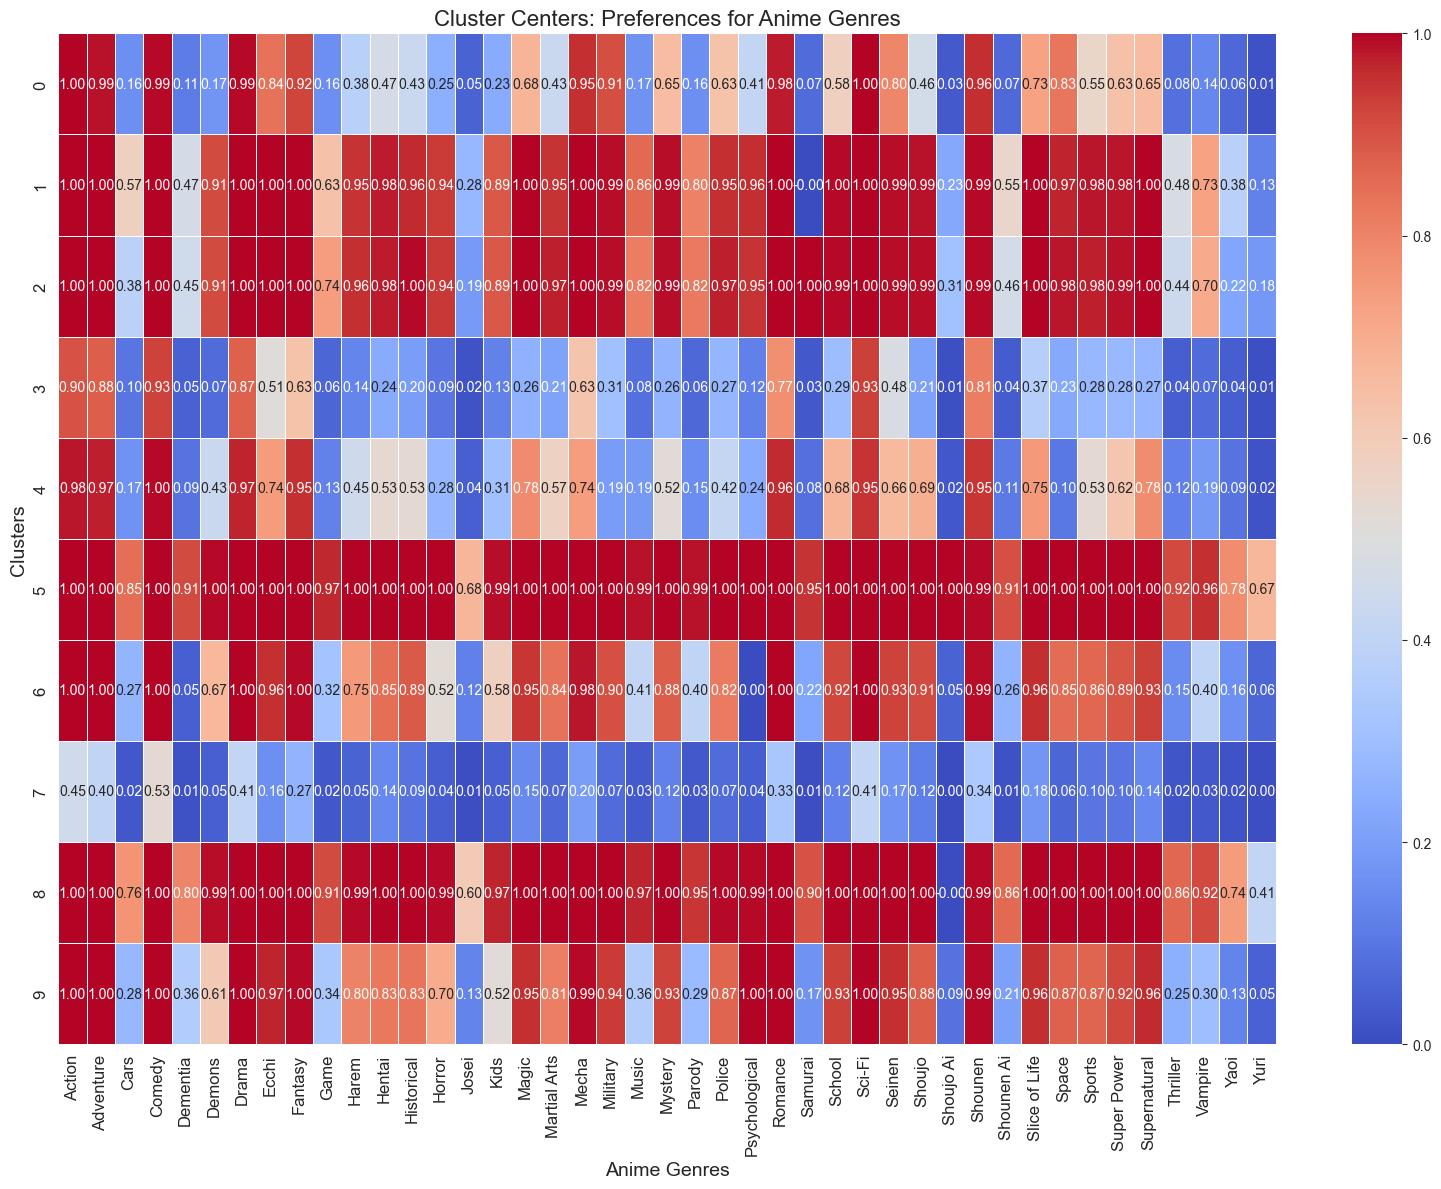

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_centers = kmeans.cluster_centers_

cluster_centers_df = pd.DataFrame(cluster_centers, columns=scaled_df.columns[:-1])

plt.figure(figsize=(16, 12))  

sns.heatmap(cluster_centers_df, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 10})

plt.title('Cluster Centers: Preferences for Anime Genres', fontsize=16)
plt.xlabel('Anime Genres', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

100%|██████████| 29/29 [09:31<00:00, 19.71s/it]


Text(0, 0.5, '$J(C_k)$')

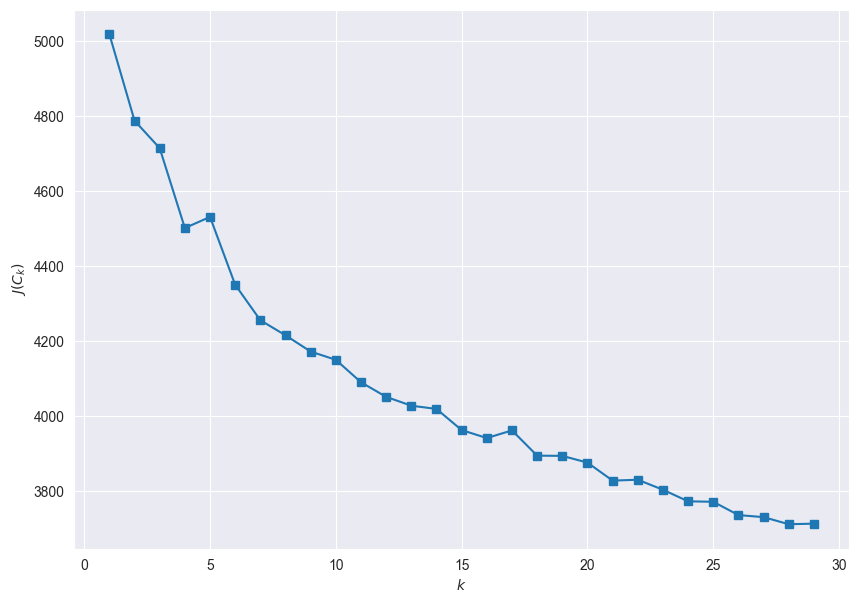

In [24]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(df))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. 

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [27]:
# from sklearn.metrics import silhouette_score, silhouette_samples
# 
# def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
#     scores = []
#     for n_clusters in tqdm(range_n_clusters):
#         clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#         cluster_labels = clusterer.fit_predict(X)
#         silhouette_avg = silhouette_score(X, cluster_labels)
#         scores.append(silhouette_avg)
#     plt.plot(range_n_clusters, scores)
#     return range_n_clusters[np.argmax(scores)]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    print("Начало расчёта коэффициента силуэта...")
    print(f"Диапазон кластеров: {range_n_clusters}")

    for n_clusters in tqdm(range_n_clusters):
        try:
            print(f"\nОбработка для числа кластеров: {n_clusters}")
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)
            silhouette_avg = silhouette_score(X, cluster_labels)
            print(f"Средний силуэт для {n_clusters} кластеров: {silhouette_avg:.4f}")
            scores.append(silhouette_avg)
        except Exception as e:
            print(f"Ошибка при обработке {n_clusters} кластеров: {e}")

    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, scores, marker='o')
    plt.xlabel('Число кластеров')
    plt.ylabel('Коэффициент силуэта')
    plt.title('Анализ коэффициента силуэта')
    plt.grid()
    plt.show()

    best_k = range_n_clusters[np.argmax(scores)]
    print(f"\nОптимальное число кластеров: {best_k} с коэффициентом силуэта {max(scores):.4f}")
    return best_k


In [28]:
draw_sil_score(scaler.fit_transform(df), range(2, 30))


Начало расчёта коэффициента силуэта...
Диапазон кластеров: range(2, 30)


  0%|          | 0/28 [00:00<?, ?it/s]


Обработка для числа кластеров: 2


  0%|          | 0/28 [02:28<?, ?it/s]


KeyboardInterrupt: 

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

Начало расчёта инерции для метода локтя...


100%|██████████| 30/30 [07:18<00:00, 14.60s/it]


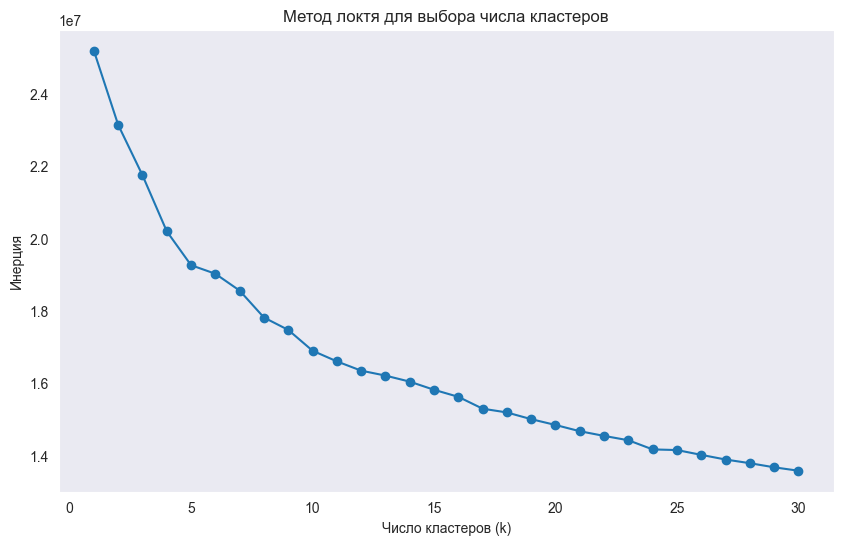

Начало расчёта коэффициента силуэта...


  0%|          | 0/13 [00:00<?, ?it/s]

Обрабатывается число кластеров: 2


  0%|          | 0/13 [00:31<?, ?it/s]


KeyboardInterrupt: 

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

def find_optimal_k_elbow(X, max_k=30):
    inertia = []
    print("Начало расчёта инерции для метода локтя...")
    for k in tqdm(range(1, max_k + 1)):
        kmeans = KMeans(n_clusters=k, random_state=10)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), inertia, marker='o')
    plt.xlabel('Число кластеров (k)')
    plt.ylabel('Инерция')
    plt.title('Метод локтя для выбора числа кластеров')
    plt.grid()
    plt.show()

find_optimal_k_elbow(scaled_data)

def find_optimal_k_silhouette(X, range_n_clusters):
    scores = []
    print("Начало расчёта коэффициента силуэта...")
    for n_clusters in tqdm(range_n_clusters):
        print(f"Обрабатывается число кластеров: {n_clusters}")
        try:
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)
            silhouette_avg = silhouette_score(X, cluster_labels)
            scores.append(silhouette_avg)
            print(f"Средний силуэт для {n_clusters} кластеров: {silhouette_avg:.4f}")
        except Exception as e:
            print(f"Ошибка при обработке {n_clusters} кластеров: {e}")
            scores.append(None)
    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, scores, marker='o')
    plt.xlabel('Число кластеров (k)')
    plt.ylabel('Коэффициент силуэта')
    plt.title('Анализ коэффициента силуэта')
    plt.grid()
    plt.show()

    valid_scores = [s for s in scores if s is not None]
    best_k = range_n_clusters[np.argmax(valid_scores)]
    print(f"\nОптимальное число кластеров по силуэту: {best_k}")
    return best_k


optimal_k = find_optimal_k_silhouette(scaled_data, range(2, 15))

print(f"\nОбучаем KMeans с {optimal_k} кластерами...")
kmeans = KMeans(n_clusters=optimal_k, random_state=10)
kmeans.fit(scaled_data)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns)
plt.figure(figsize=(12, 8))
sns.heatmap(centroids, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Тепловая карта центроидов кластеров")
plt.xlabel("Жанры")
plt.ylabel("Кластеры")
plt.show()


### 18. Порекомендуйте что-нибудь абстрактному пользователю. 
Это можно сделать разными способами. Как это сделать подумайте сами. 

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен. 
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.



In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

def find_optimal_k_silhouette(X, range_n_clusters):
    scores = []
    print("Начало расчёта коэффициента силуэта...")
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
        print(f"Средний силуэт для {n_clusters} кластеров: {silhouette_avg:.4f}")
    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, scores, marker='o')
    plt.xlabel('Число кластеров (k)')
    plt.ylabel('Коэффициент силуэта')
    plt.title('Анализ коэффициента силуэта')
    plt.grid()
    plt.show()

    best_k = range_n_clusters[np.argmax(scores)]
    print(f"\nОптимальное число кластеров по силуэту: {best_k}")
    return best_k

optimal_k = find_optimal_k_silhouette(scaled_data, range(2, 15))

print(f"\nОбучаем KMeans с {optimal_k} кластерами...")
kmeans = KMeans(n_clusters=optimal_k, random_state=10)
kmeans.fit(scaled_data)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns[:kmeans.cluster_centers_.shape[1]])

plt.figure(figsize=(12, 8))
sns.heatmap(centroids, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Тепловая карта центроидов кластеров")
plt.xlabel("Жанры")
plt.ylabel("Кластеры")
plt.show()

df['Cluster'] = kmeans.labels_

recommendations = {}
for cluster_id in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster_id]
    
    genre_importance = centroids.iloc[cluster_id].sort_values(ascending=False)
    top_anime = cluster_data.sort_values(by='Rating', ascending=False).head(10) 
    recommendations[cluster_id] = {
        'Top Genres': genre_importance.head(5).index.tolist(),
        'Top Anime': top_anime[['Title', 'Rating']].values.tolist()
    }
    
for cluster_id, rec in recommendations.items():
    print(f"\nКластер {cluster_id}:")
    print(f"Топ жанры: {', '.join(rec['Top Genres'])}")
    print("Рекомендуемые аниме:")
    for anime in rec['Top Anime']:
        print(f" - {anime[0]} (Рейтинг: {anime[1]})")


Начало расчёта коэффициента силуэта...


  0%|          | 0/13 [00:32<?, ?it/s]


KeyboardInterrupt: 